In [1]:
# Third-party imports
from math import ceil
import vrplib
import os
import numpy as np

# Own imports
from src.new.display import DisplayModel
from src.new.aco import FreeAnt
from src.new.acs import AS
from src.new.helpers import create_directory, download_instance, get_distances_matrix
from src.new.heuristics import HeuristicModel
from src.new.metaheuristics import GeneralVNS
from src.new.models import VRPModel

In [2]:
# Parameters to handle the algorithm
%matplotlib inline

ALPHA = 1  # 0.75, 1, 1.05, 1.1, 1.25, 1.5, 1.75, 2
ANTS_NUM_RELATION = 2  # 1, 2
BETA = 3  # 2, 2.5, 3,  3.5
GAMMA = 2  # 1, 1.5 2
# ['distance'], ['saving'], ['distance', 'saving']
HEURISTICS_TO_USE = ['distance', 'saving']
INSTANCE = 'instances/CVRPLIB/CMT/CMT1'
ITERATION_LOCAL_SEARCH_MODEL = None  # None, GeneralVNS
MAX_ITERATIONS = 500
MIN_ITERATIONS = 200
P = 0.1  # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
P_M = 0.1  # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
PROBABILITIES_MATRIX_TYPE = 'classic'  # 'classic', 'normalized'
TARE_PERCENTAGE = 0.15

# Instance to solve
LIB = 'CMT'
INSTANCE = 'CMT1'

# Parameters to handle the display
PLOT_INSTANCE = False
PLOT_SOLUTION = True

In [3]:
# Initialize everything
project_path = os.getcwd()
instance_file_exists = os.path.isfile(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')

if not instance_file_exists:
    create_directory(f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}/')
    success = download_instance(
        INSTANCE, f'{project_path}/instances/CVRPLIB/{LIB}/')

    if not success:
        raise Exception('Error downloading the instance')


instance = vrplib.read_instance(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')
solution = vrplib.read_solution(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.sol')

demands = instance['demand']
nodes = [node for node in range(len(demands))]
clients = nodes[1:]
max_capacity = instance['capacity']
matrix_coords = instance['node_coord']
k_optimal = ceil(sum(demands)/max_capacity)

optimal_cost = None
if solution['cost']:
    optimal_cost = solution['cost']
else:
    optimal_cost = float(instance['comment']) if instance['comment'] else None

errors = VRPModel.validate_instance(nodes, demands, max_capacity)
if errors:
    raise Exception(errors)

iterations = max(round(len(nodes), -2), MIN_ITERATIONS)
matrix_distances = get_distances_matrix(nodes, matrix_coords)

parameters_heuristics = {
    'demands': demands,
    'importance_distances': BETA,
    'importance_savings': GAMMA,
    'matrix_coords': matrix_coords,
    'nodes': nodes,
}

heuristics = HeuristicModel(**parameters_heuristics)
matrix_heuristics = heuristics.get_heuristic_matrix(HEURISTICS_TO_USE)

parameters_ants = {
    'alpha': ALPHA,
    'ants_num': ceil(len(clients) / ANTS_NUM_RELATION),
    'beta': BETA,
    'demands': demands,
    'ipynb': True,
    'k_optimal': k_optimal,
    'matrix_costs': matrix_distances,
    'matrix_heuristics': matrix_heuristics,
    'max_capacity': max_capacity,
    'max_iterations': min(iterations, MAX_ITERATIONS),
    'model_ant': FreeAnt,
    'model_ls_it': ITERATION_LOCAL_SEARCH_MODEL,
    'model_problem': VRPModel,
    'nodes': nodes,
    'p_m': P_M,
    'p': P,
    'tare': max_capacity * TARE_PERCENTAGE,
}

In [4]:
# Render the problem

if PLOT_INSTANCE:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_problem(nodes, demands, matrix_coords, instance_name)

In [5]:
# Run the algorithm

ant_system = AS(**parameters_ants)
global_best_solution, best_solutions, costs_mean, costs_median, _, _ = ant_system.solve()


PARAMETERS:
	alpha: 1
	ants_num: 25
	arcs_clusters_importance: 0
	beta: 3
	demands: [ 0  7 30 16  9 21 15 19 23 11  5 19 29 23 21 10 15  3 41  9 28  8  8 16
 10 28  7 15 14  6 19 11 12 23 26 17  6  9 15 14  7 27 13 11 16 10  5 25
 17 18 10]
	evaporation_rate: 0.8
	k_optimal: 5
	max_capacity: 160
	max_iterations: 200
	p: 0.1
	tare: 24.0
	type_probabilities_matrix: normal




Global Best: 600.73479: 100%|██████████| 200/200 [00:05<00:00, 39.88it/s]


-- Time elapsed: 5.017306566238403 --

BEST SOLUTION FOUND: (600.7347911420791, [[0, 46, 12, 47, 4, 18, 25, 14, 0], [0, 5, 49, 30, 34, 50, 9, 38, 11, 32, 22, 0], [0, 6, 48, 8, 26, 31, 28, 3, 20, 35, 36, 29, 0], [0, 27, 1, 2, 16, 21, 10, 39, 33, 45, 15, 44, 17, 0], [0, 23, 7, 43, 24, 13, 41, 19, 40, 42, 37, 0]], 5, [158, 159, 160, 156, 144])
Best 5 solutions: [(600.7347911420791, 5, [158, 159, 160, 156, 144]), (608.9391368103436, 5, [158, 158, 155, 154, 152]), (609.3741977679416, 5, [158, 160, 159, 158, 142]), (609.3741977679417, 5, [158, 160, 158, 159, 142]), (611.3184640592559, 5, [158, 160, 159, 160, 140])]


TypeError: 'numpy.float64' object is not iterable

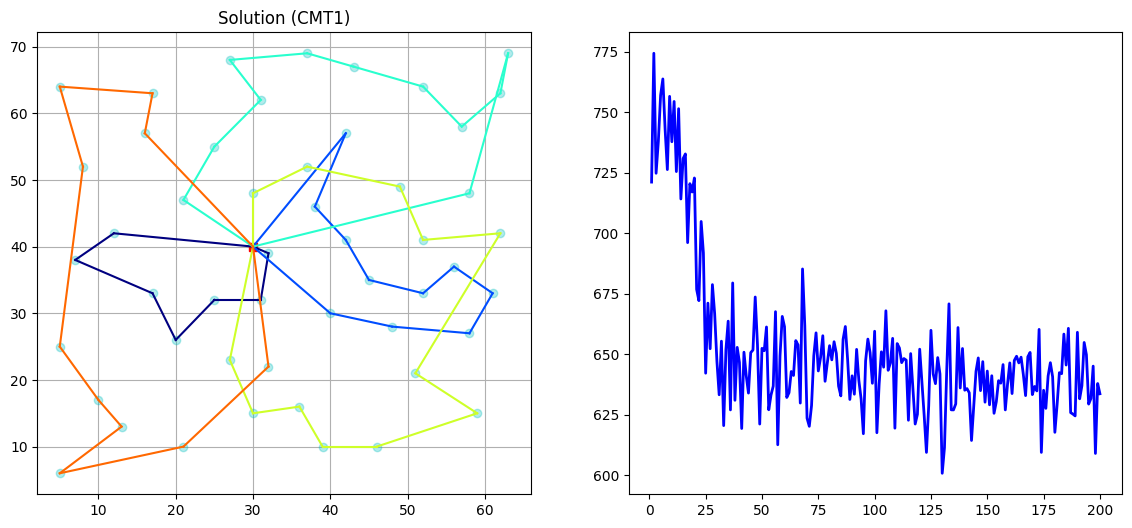

In [6]:
if PLOT_SOLUTION:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_solution(global_best_solution, matrix_coords,
                                 instance_name, best_solutions, costs_mean, costs_median)
